<a href="https://colab.research.google.com/github/sg-peytrignet/algeria24-training/blob/main/3_fiber_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fiber path modeling

## Setting up our environment

In this section, we import the necessary Python libraries for our fiber path modeling:

Data handling tools (pandas, numpy) for efficient data manipulation
Network analysis tools (networkx) for creating and analyzing network graphs
Spatial libraries (geopandas, scipy) for geographic calculations
Visualization tools (matplotlib, folium) for displaying our results
Additional utilities for improved functionality

In [1]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 27.3 MB/s eta 0:00:00


In [2]:
# Data handling
import pandas as pd
import numpy as np

# Efficient queueing and combinatorics
import heapq
import itertools

# Graph and spatial libraries
import networkx as nx
import geopandas as gpd
from scipy.spatial import cKDTree

# Visualization
import matplotlib.pyplot as plt
import folium

# Miscellaneous utilities
from tqdm import tqdm
import pycountry

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

The option `display_folium` controls whether to display interactive maps, which can be heavy and prevent the markdown file from displaying correctly.

In [3]:
display_folium = True

## Set analysis parameters

Here we create an interactive interface that allows us to:

- Select a country from a dropdown menu
- Set the maximum fiber length use to connect each point of interest

These parameters will influence how our network is constructed and how schools can be connected to fiber nodes. You need to click play button of the controls cell each time you change the parameters.

In [4]:
#@title
# Define the layout for the input fields
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

item_layout2 = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Create the input fields
country = widgets.Dropdown(
    description='Country:',
    options=list(map(lambda x: x.name, pycountry.countries)),
    value='Algeria',
    layout=item_layout2,
    style={'description_width': 'initial'}
)

maximum_connection_length = widgets.FloatSlider(
    description='Maximum Connection Length (km):',
    min=0,
    max=100,
    step=1,
    value=15,
    layout=item_layout,
    style={'description_width': 'initial'}
)

# Create a container to hold the input fields
inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([country], layout=widgets.Layout(justify_content='space-between')),
        widgets.HBox([maximum_connection_length], layout=widgets.Layout(justify_content='space-between')),
    ]
)

# Display the input fields
display(inputs_layout)

## Download school dataset

We load data about school locations in Algeria from a public dataset. Each school is represented by:

- Geographic coordinates (latitude and longitude)
- Unique identifiers
- Additional metadata

We convert this into a GeoDataFrame to enable spatial operations.

In [5]:
algeria_schools = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_schools.csv")

In [6]:
algeria_schools_gdf = gpd.GeoDataFrame(algeria_schools[["poi_id","dataset_id","lat","lon"]], geometry=gpd.points_from_xy(algeria_schools.lon, algeria_schools.lat), crs='EPSG:4326')
algeria_schools_gdf = algeria_schools_gdf.rename(columns={"poi_id":"id"}, inplace=False)
algeria_schools_gdf["label"] = "unconnected_school"

In [7]:
algeria_schools_gdf.head()

,id,dataset_id,lat,lon,geometry,label
0,8dd444f0-2eb1-4d9a-bf57-f032e51768e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.949701,3.580467,POINT (3.58047 31.9497),unconnected_school
1,a1c86f79-a20e-4001-9ac0-def0831024f1,34500f3d-aec9-418b-81ff-1a77d23ba047,31.976883,3.743190,POINT (3.74319 31.97688),unconnected_school
2,cb814cd6-0c90-49d6-b847-d163a95e77e0,34500f3d-aec9-418b-81ff-1a77d23ba047,31.950062,3.541530,POINT (3.54153 31.95006),unconnected_school
3,194188d3-94b1-4e03-a002-25e8c868bfae,34500f3d-aec9-418b-81ff-1a77d23ba047,31.952468,3.529267,POINT (3.52927 31.95247),unconnected_school
4,c32d3c71-c574-4701-b761-ec757dbe2d4f,34500f3d-aec9-418b-81ff-1a77d23ba047,31.601909,3.676841,POINT (3.67684 31.60191),unconnected_school


## Download transmission node dataset

Similar to the school dataset, we load information about fiber transmission nodes. These are the existing connection points in our network that schools can potentially connect to.

In [8]:
algeria_nodes = pd.read_csv("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/algeria/processed/formatted_algeria_nodes.csv")

In [9]:
algeria_nodes_gdf = gpd.GeoDataFrame(algeria_nodes[["ict_id","dataset_id","lat","lon"]], geometry=gpd.points_from_xy(algeria_nodes.lon, algeria_nodes.lat), crs='EPSG:4326')
algeria_nodes_gdf = algeria_nodes_gdf.rename(columns={"ict_id":"id"}, inplace=False)
algeria_nodes_gdf["label"] = "fiber_node"

In [10]:
algeria_nodes_gdf.head()

,id,dataset_id,lat,lon,geometry,label
0,ada877d8-df1a-4d60-b86a-6561eca45f6c,1a452a88-1f87-4910-95ed-45179330f4a0,36.480870,2.835004,POINT (2.835 36.48087),fiber_node
1,4f32bf64-8ccf-4748-9834-024426d1436b,1a452a88-1f87-4910-95ed-45179330f4a0,36.135791,2.915544,POINT (2.91554 36.13579),fiber_node
2,2fee309c-5ee3-4cd2-9dd7-97c181730057,1a452a88-1f87-4910-95ed-45179330f4a0,36.766537,3.467671,POINT (3.46767 36.76654),fiber_node
3,1fed4fe3-7010-44b3-8879-fb419cee8114,1a452a88-1f87-4910-95ed-45179330f4a0,36.508079,1.314256,POINT (1.31426 36.50808),fiber_node
4,dd73c0b1-b9ec-4bdb-82f8-d63c3621fc10,1a452a88-1f87-4910-95ed-45179330f4a0,35.483203,-0.598996,POINT (-0.599 35.4832),fiber_node


## Combine both datasets

We merge the school and fiber node datasets into a single DataFrame. This combined dataset will form the basis of our network analysis, containing both potential connection points (transmission nodes) and locations needing connection (schools).

In [11]:
df_locations = pd.concat([algeria_schools_gdf, algeria_nodes_gdf]).set_index('id')

## Select a city

We implement interactive functionality to choose a specific city in Algeria for our fiber path modelling. This is to make the problem smaller and faster to solve. You need to click play button of the controls cell each time you change the parameter.

In [12]:
# @title
# Define the layout for the input fields
item_layout = widgets.Layout(
    width='auto',
    min_width='20px',
    flex='1 1 auto',
    display='flex',
    flex_flow='row wrap',
    align_items='center',
    justify_content='space-between'
)

# Create the city dropdown
city_centroids = pd.DataFrame({"city": ["Sidi Bel Abbes"], "lat": [35.1917], "lon": [-0.6417]})
list(city_centroids["city"].unique())
city = widgets.Dropdown(
    description='City:',
    options=list(city_centroids["city"].unique()),
    value=city_centroids["city"][0],
    layout=item_layout,
    style={'description_width': 'initial'}
)

# Create a container to hold the dropdown
inputs_layout = widgets.VBox(
    children=[
        widgets.HBox([city], layout=widgets.Layout(justify_content='space-between')),
    ]
)

# Display the widget
display(inputs_layout)

In [13]:
# @title Function
def find_locations_within_distance(reference_point, locations_df, max_distance, earth_radius=6371):
    """Find all locations within a specified distance of a reference point.
    Args:
        reference_point: (longitude, latitude) tuple
        locations_df: DataFrame with 'lon' and 'lat' columns
        max_distance: maximum distance in same units as coordinates
    Returns:
        DataFrame containing locations within the specified distance
    """
    # Create a KDTree using the locations
    kdtree = cKDTree(locations_df[['lon', 'lat']].values)

    # Find all points within max_distance, after converting to degrees
    radius = max_distance * np.rad2deg(1/earth_radius)
    indices = kdtree.query_ball_point(np.array(reference_point), radius)

    # Get the distances for the found points
    if indices:
        distances = kdtree.query(np.array(reference_point), k=len(indices))[0]
        distances = np.deg2rad(distances) * earth_radius
        result_df = locations_df.iloc[indices].copy()
        result_df['distance'] = distances
        return result_df.sort_values('distance')
    else:
        return pd.DataFrame()

In [14]:
selected_centroid = city_centroids.loc[city_centroids.city == city.value, ['lon', 'lat']].values[0]
filtered_locations = find_locations_within_distance(selected_centroid, df_locations, max_distance=2)
connected_idx = filtered_locations.loc[df_locations.label != 'unconnected_school'].index
unconnected_idx = filtered_locations.loc[df_locations.label == 'unconnected_school'].index

In [15]:
assert len(connected_idx) > 0, "There are no fiber nodes in the selected area"
assert len(unconnected_idx) > 0, "There are no schools in the selected area"
print(f"There are {len(connected_idx)} fiber nodes and {len(unconnected_idx)} schools in the selected area.")

There are 1 fiber nodes and 46 schools in the selected area.


## Create line of sight (LOS) graph

This is where we build our network model:

- The `haversine` function calculates distances between points on Earth's surface
- The `generate_all_index_pairs` function creates possible connections between locations
- The `create_line_of_sight_graph` function builds a network graph where:
    - Nodes represent schools and fiber points
    - Edges represent possible connections
    - Edge weights are distances in meters

In [16]:
# @title Function
def haversine(lats, lons, R=6371.0, upper_tri=False):
    """Calculate great circle distances between points on Earth using the Haversine formula.

    The Haversine formula determines the great-circle distance between two points on a sphere
    given their longitudes and latitudes.

    Args:
        lats (array-like): Array of latitude values in decimal degrees
        lons (array-like): Array of longitude values in decimal degrees
        R (float, optional): Earth's radius in kilometers. Defaults to 6371.0 km
        upper_tri (bool, optional): If True, returns only upper triangular part of distance matrix

    Returns:
        ndarray: Distance matrix in kilometers (full or upper triangular based on upper_tri)
    """
    # Convert latitude and longitude to radians for trigonometric calculations
    lat_rads = np.radians(lats)
    lon_rads = np.radians(lons)

    # Create distance matrix using broadcasting
    # Each element (i,j) will be distance between points i and j
    dlat = lat_rads[:, np.newaxis] - lat_rads[np.newaxis, :]  # Latitude differences
    dlon = lon_rads[:, np.newaxis] - lon_rads[np.newaxis, :]  # Longitude differences

    # Haversine formula components
    a = (np.sin(dlat/2)**2 +
         np.cos(lat_rads[:, np.newaxis]) *
         np.cos(lat_rads[np.newaxis, :]) *
         np.sin(dlon/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    # Calculate final distances
    distances = R * c

    # Return only upper triangular part if requested
    if upper_tri:
        i_upper = np.triu_indices(distances.shape[0], k=1)
        distances = distances[i_upper]

    return distances

def generate_all_index_pairs(vals):
    """Generate all possible pairs of indices from a list of values.

    Creates unique combinations of indices without repetition and without order
    (i.e., (a,b) but not (b,a)).

    Args:
        vals (list): List of values to generate pairs from

    Returns:
        tuple: Two lists containing paired indices (origin_nodes, destination_nodes)
    """
    # Generate unique pairs using itertools.combinations
    # This ensures no duplicate pairs and no self-pairs
    index_pairs = itertools.combinations(vals, 2)

    # Split pairs into separate lists for origin and destination
    orig_nodes, dest_nodes = zip(*index_pairs)

    return orig_nodes, dest_nodes

def create_line_of_sight_graph(locations):
    """Create a graph representing line-of-sight connections between locations.

    Builds an undirected graph where edges represent potential connections between
    locations, weighted by their geodesic distances.

    Args:
        locations (DataFrame): DataFrame containing 'lat' and 'lon' columns

    Returns:
        networkx.Graph: Undirected graph with weighted edges representing distances
    """
    # Get all possible pairs of location indices
    orig_nodes, dest_nodes = generate_all_index_pairs(locations.index)

    # Calculate distances in meters (converting km to m by multiplying by 1000)
    distances = haversine(
        locations.lat.to_numpy(),
        locations.lon.to_numpy(),
        upper_tri=True
    ) * 1000

    # Create undirected graph and add weighted edges
    graph = nx.Graph()
    graph.add_weighted_edges_from(zip(orig_nodes, dest_nodes, distances))

    return graph

def draw_graph_with_connected_nodes(graph, connected, figsize=(10, 10)):
    """Visualize network graph with highlighted connected nodes.

    Creates a visualization where nodes are colored based on their connection status
    and includes a legend for node types.

    Args:
        graph (networkx.Graph): Network graph to visualize
        connected (set or list): Nodes that are connected/transmission nodes
        figsize (tuple, optional): Figure size. Defaults to (10, 10)
    """
    plt.figure(figsize=figsize)

    # Calculate spring layout for node positions
    pos = nx.spring_layout(graph)

    # Ensure connected is a set for efficient lookup
    connected = set(connected) if not isinstance(connected, set) else connected

    # Color nodes based on connection status
    node_colors = ['red' if node in connected else 'skyblue' for node in graph.nodes()]

    # Draw the network
    nx.draw(graph,
           pos=pos,
           with_labels=False,
           node_size=300,
           node_color=node_colors,
           font_size=10,
           font_color='black',
           edge_color='gray')

    # Create and add legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w',
                   label='Transmission Node', markerfacecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='o', color='w',
                   label='School', markerfacecolor='skyblue', markersize=10)
    ]

    plt.legend(handles=legend_elements, loc='upper right')
    plt.title("Line of Sight Graph with Connected Nodes")
    plt.show()

In [17]:
graph = create_line_of_sight_graph(filtered_locations)

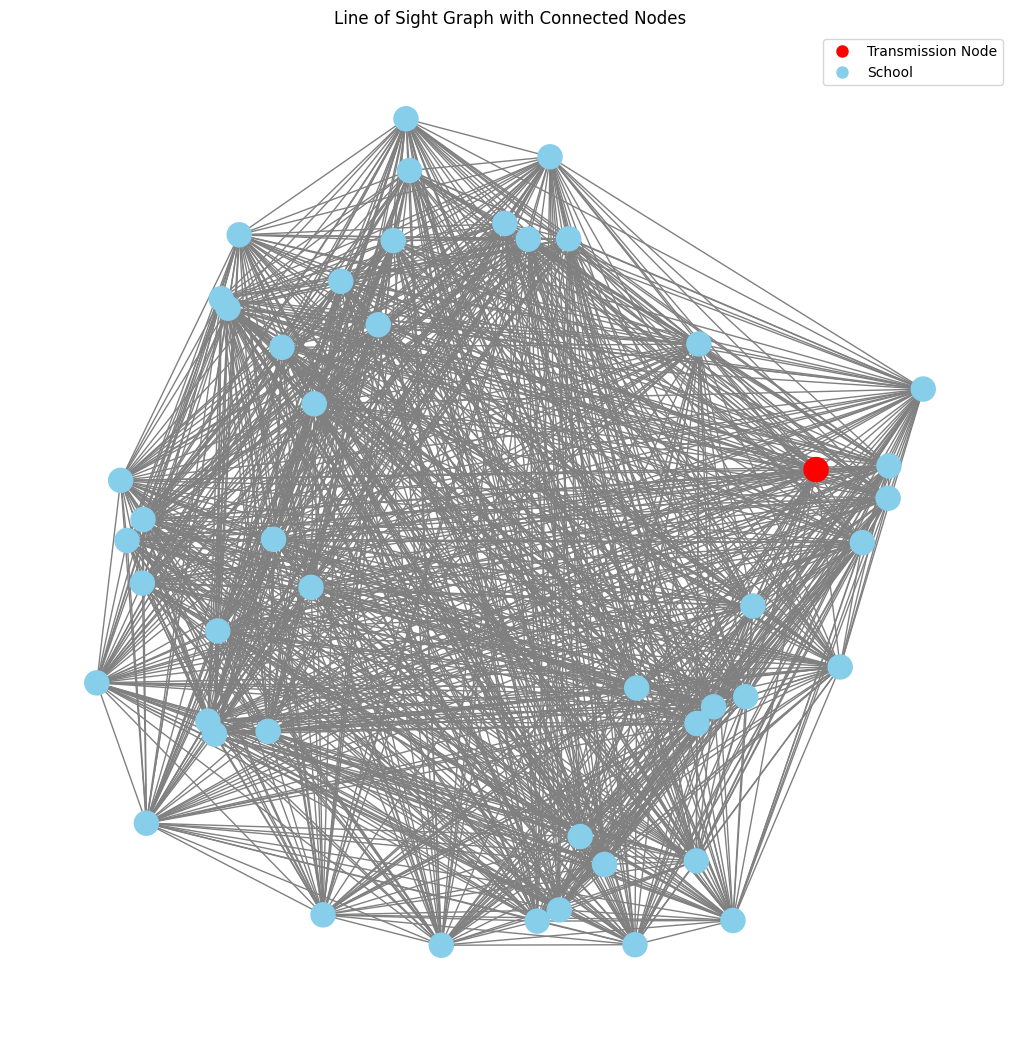

In [18]:
draw_graph_with_connected_nodes(graph, connected_idx)

## Connect unconnected schools

This section implements the core algorithm for connecting schools to the fiber network:

1. Identifies the closest transmission node for each school
2. Uses a priority queue to process connections in order of shortest distance
3. Iteratively builds connections while respecting maximum distance constraints
4. Tracks the path and distance information for each connection

In [19]:
# @title Algorithm
def connect_schools(locations, connected_idx, max_connection_length, graph_, scale_economies=True):
    """
    Connects unconnected schools to the nearest connected school dynamically using the given graph.
    Returns a DataFrame containing the fiber path information for each school.

    Args:
        locations : DataFrame of all locations where the index is the location identifier.
        connected_idx: List of indices that are either fiber nodes or points connected with fiber.
        max_connection_length: Maximum length of cable that can be used to connect an unconnected location.
        graph_ : Networkx graph object representing the line of sight graph.
        scale_economies: If True, the algorithm will enable connected schools to act as fiber nodes to extend the connection.

    Returns:
        fiber_path_df (DataFrame): DataFrame containing the fiber path and other information for each school that is connected to the network.
        connected_idx (set): Updated set of connected school indices after connection.
    """

    # Copy the list of connected indices and initialize sets of connected and unconnected indices
    connected_idx_cache = connected_idx
    connected_idx = set(connected_idx)
    unconnected_idx = set(locations.index) - connected_idx
    initial_unconnected = len(unconnected_idx)

    # Generate pairs of unconnected and connected school indices for shortest path calculations
    ind = itertools.product(unconnected_idx, connected_idx)
    orig_nodes, dest_nodes = zip(*ind)

    # Calculate shortest path lengths between each unconnected and connected school
    sp_lengths = []
    print("Calculating shortest path lengths...")
    for orig_node, dest_node in tqdm(zip(orig_nodes, dest_nodes), total=len(orig_nodes)):
        sp_lengths.append(nx.shortest_path_length(graph_, orig_node, dest_node, weight='weight'))

    # Reshape distances into a matrix to find the closest connected school for each unconnected school
    dist_to_connected = np.array(sp_lengths).reshape(len(unconnected_idx), len(connected_idx))
    closest_connected_id = connected_idx_cache[np.argmin(dist_to_connected, axis=1)]
    closest_connected_distance = np.min(dist_to_connected, axis=1)

    # Create a dictionary to store fiber path information for each school
    fiber_path_dict = dict.fromkeys(locations.index)

    # Initialize fiber path data for schools that are already connected
    fiber_path_dict.update({idx: dict(
                                closest_node_id=idx,
                                closest_node_distance=0,
                                connected_node_id=idx,
                                connected_node_distance=0,
                                fiber_path=[]
                            ) for idx in connected_idx})

    # Initialize path information for unconnected schools with nearest connected school details
    fiber_path_dict.update([(idx, dict(
                                closest_node_id=closest_connected_id[i],
                                closest_node_distance=closest_connected_distance[i],
                                connected_node_id='',
                                connected_node_distance=0,
                                fiber_path=[]
                            )) for i, idx in enumerate(unconnected_idx)])

    # Initialize a priority queue to hold possible connections below the maximum cable length
    queue = []
    for d_ in zip(sp_lengths, orig_nodes, dest_nodes):
        if d_[0] <= max_connection_length:
            heapq.heappush(queue, d_)

    # Main loop to iteratively connect each unconnected school to the network
    print("Connecting schools...")

    # Initialize progress bar for connected schools
    with tqdm(total=len(unconnected_idx), desc="Schools Connected") as pbar:
        while queue:
            # Get the shortest valid connection from the priority queue
            min_dist, min_node, upstream_node = heapq.heappop(queue)

            # If the node is already connected, skip to the next
            if min_node in connected_idx:
                continue

            # If the connection is within the allowed distance, add it to the connected set
            if min_dist <= max_connection_length:
                connected_idx.add(min_node)
                unconnected_idx.remove(min_node)

                # Update fiber path information for the newly connected node
                fiber_path_dict[min_node].update(
                    connected_node_id=fiber_path_dict[upstream_node]['connected_node_id'],
                    connected_node_distance=nx.shortest_path_length(graph_, min_node, upstream_node, weight='weight') + fiber_path_dict[upstream_node]['connected_node_distance'],
                    upstream_node_id=upstream_node,
                    upstream_node_distance=min_dist,
                    fiber_path=fiber_path_dict[upstream_node]['fiber_path'] + [upstream_node]
                )

                # Update the progress bar
                pbar.update(1)

                # Exit if all schools are connected
                if len(unconnected_idx) == 0:
                    break

                # Only process new connections if scale_economies is True
                if scale_economies:
                    # Generate new connections from the newly connected node to remaining unconnected schools
                    ind = itertools.product(unconnected_idx, [min_node])
                    orig_nodes, dest_nodes = zip(*ind)

                    # Calculate shortest path lengths for new possible connections
                    new_sp_lengths = []
                    for orig_node, dest_node in zip(orig_nodes, dest_nodes):
                        new_sp_lengths.append(nx.shortest_path_length(graph_, orig_node, dest_node, weight='weight'))

                    # Add new valid connections to the priority queue
                    for d_ in zip(new_sp_lengths, orig_nodes, dest_nodes):
                        if d_[0] <= max_connection_length:
                            heapq.heappush(queue, d_)

    # Convert the fiber path dictionary to a DataFrame for easy handling
    fiber_path_df = pd.DataFrame(fiber_path_dict.values(), index=fiber_path_dict.keys())
    return fiber_path_df, connected_idx

In [20]:
fiber_path_df, fiber_path_connected_idx = connect_schools(filtered_locations, connected_idx, maximum_connection_length.value * 1000, graph, scale_economies=True)

Calculating shortest path lengths...


100%|██████████| 46/46 [00:00<00:00, 404.34it/s]


Connecting schools...


Schools Connected: 100%|██████████| 46/46 [00:02<00:00, 18.52it/s]


In [21]:
fiber_path_df.head(10)

,closest_node_id,closest_node_distance,connected_node_id,connected_node_distance,fiber_path,upstream_node_id,upstream_node_distance
dcbd98e6-7a75-457f-a40a-f6bbf3c22b48,6894789c-de2c-4ea3-985f-35ce2ae98960,1853.428719,6894789c-de2c-4ea3-985f-35ce2ae98960,4058.641423,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",28f04616-44b4-47c0-a6bb-a7aa88ee4f00,325.465354
c27df4a3-be7c-407a-90e3-11b06961b8d8,6894789c-de2c-4ea3-985f-35ce2ae98960,1498.682688,6894789c-de2c-4ea3-985f-35ce2ae98960,4108.769234,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",28f04616-44b4-47c0-a6bb-a7aa88ee4f00,375.593166
adc07710-0028-4198-8bf4-04210d470a3c,6894789c-de2c-4ea3-985f-35ce2ae98960,1532.713157,6894789c-de2c-4ea3-985f-35ce2ae98960,3193.575070,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",62238aa5-d0e8-4835-85a6-e74ced7ed873,256.179431
28f04616-44b4-47c0-a6bb-a7aa88ee4f00,6894789c-de2c-4ea3-985f-35ce2ae98960,1535.696452,6894789c-de2c-4ea3-985f-35ce2ae98960,3733.176068,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",3e9f0a47-c30c-4c81-9682-ddac21d768ae,202.622185
3e9f0a47-c30c-4c81-9682-ddac21d768ae,6894789c-de2c-4ea3-985f-35ce2ae98960,1616.137223,6894789c-de2c-4ea3-985f-35ce2ae98960,3530.553883,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",adc07710-0028-4198-8bf4-04210d470a3c,336.978813
55a7072c-c613-4a62-a720-568bb64167c1,6894789c-de2c-4ea3-985f-35ce2ae98960,999.424498,6894789c-de2c-4ea3-985f-35ce2ae98960,4282.214936,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",28f04616-44b4-47c0-a6bb-a7aa88ee4f00,549.038868
96575839-9ff7-4142-9850-7c50432a81f3,6894789c-de2c-4ea3-985f-35ce2ae98960,921.378861,6894789c-de2c-4ea3-985f-35ce2ae98960,4368.703744,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",55a7072c-c613-4a62-a720-568bb64167c1,86.488808
14ca1248-5acc-497f-bbac-f3d38fcda6d6,6894789c-de2c-4ea3-985f-35ce2ae98960,2020.931263,6894789c-de2c-4ea3-985f-35ce2ae98960,3549.024856,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",8d5d7d6f-762a-4b81-8155-eb8c9d9c1478,102.093205
e9d370da-849e-4a67-8123-2bc9e815d040,6894789c-de2c-4ea3-985f-35ce2ae98960,2383.246522,6894789c-de2c-4ea3-985f-35ce2ae98960,3971.474221,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",c889f858-23aa-4519-ab7a-7cefbbb68dd8,297.357849
8d5d7d6f-762a-4b81-8155-eb8c9d9c1478,6894789c-de2c-4ea3-985f-35ce2ae98960,2083.375372,6894789c-de2c-4ea3-985f-35ce2ae98960,3446.931650,"[6894789c-de2c-4ea3-985f-35ce2ae98960, ad6a6e6...",cad7104d-0c5f-4f51-af24-c1bfa6a2e28c,243.201867


## Visualise the fiber path solution

Finally, we create an interactive map visualization showing the connections made by the algorithm.

In [22]:
# @title Function
def create_simple_network_map(locations, df_results):
    # Create map
    m = folium.Map(
        location=[locations['lat'].mean(), locations['lon'].mean()],
        zoom_start=14
    )

    # Add points and connections
    for idx, row in locations.iterrows():
        color = 'red' if row['label'] == 'unconnected_school' else 'blue'
        folium.CircleMarker([row['lat'], row['lon']],
                          radius=5,
                          color=color,
                          fill=True).add_to(m)

    for _, row in df_results.iterrows():
        if not np.isnan(row.get('upstream_node_distance', np.nan)):
            source_loc = locations.loc[row.name]
            target_loc = locations.loc[row['upstream_node_id']]
            folium.PolyLine([[source_loc['lat'], source_loc['lon']],
                            [target_loc['lat'], target_loc['lon']]],
                           color='purple',
                           weight=2).add_to(m)

    # Add legend with colored symbols
    legend = """
    <div style="
        position: absolute;
        top: 10px;
        right: 10px;
        z-index: 9999;
        background-color: white;
        padding: 10px;
        border: 2px solid black;
        border-radius: 5px;
        ">
        <div><span style="color:red">●</span> Unconnected Schools</div>
        <div><span style="color:blue">●</span> Fiber Nodes</div>
        <div><span style="color:purple">━</span> Connections</div>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend))

    return m

In [23]:
map_viz = create_simple_network_map(filtered_locations, fiber_path_df)
map_viz